Besprechung
===========

## 1. Recap: Bug bei der Mean Berechnung ("falsche" Koef.-Matrix)

* Spezifizierte Basis und tatsächlich geschätzte Basis unterscheiden sich bei der Verwendung von ```mgcv```.
* ```mgcv``` nimmt die spezifizierte Basis und implementiert noch einen "sum-to-one" constraint. Die ausgegebenen Koeffizienten gehören zur constrainten Basis.
* Die "richtigen" Koeffizienten müssen über entsprechende Basis-Trafo $D$ aus den constrainten Koeffizienten rekonstruiert werden: $\hat{\Sigma} = D \cdot \hat{\tilde{\Sigma}}$.
* $D$ wird leider nicht von ```mgcv``` mitgeliefert sondern muss extra berechnet werden über $X = D \cdot \tilde{X}$, mit $X, \tilde{X}$ Design- und constrained Designmatrix.

Ergebnisse sehen jetzt deutlich besser aus. Vor allem auch für höhere Penalties! :)

#### Example with ```penalty = 2``` (and ```elasdics``` mean on unrotated/unscaled data):

In [6]:
devtools::install("../../elasticproc2d", quiet=TRUE, quick=TRUE)

Installing 2 packages: pracma, ks




  There is a binary version available but the source version is later:
   binary source needs_compilation
ks 1.13.0 1.13.1              TRUE

  Binaries will be installed
package 'pracma' successfully unpacked and MD5 sums checked
package 'ks' successfully unpacked and MD5 sums checked


Warning message:
"cannot remove prior installation of package 'ks'"
Warning message in file.copy(savedcopy, lib, recursive = TRUE):
"problem copying C:\R\R-4.0.5\library\00LOCK\ks\libs\x64\ks.dll to C:\R\R-4.0.5\library\ks\libs\x64\ks.dll: Permission denied"
Warning message:
"restored 'ks'"


In [7]:
library(dplyr)
library(ggplot2)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




In [8]:
library(elasticproc2d)
source("../scripts/load_datasets.R")
set.seed(18)
test_curves <- curves.spiral(n_curves = 10, rotate=FALSE, scale=FALSE, center=TRUE)
set.seed(18)
data_curves2 <- curves.spiral(n_curves = 10, rotate=TRUE, scale=TRUE, center=FALSE)
data_curves1 <- curves.digit3(rotate=TRUE, scale=TRUE, center=FALSE)
knots1 <- seq(0, 1, length = 13)
knots2 <- seq(0, 1, length = 13)

In [9]:
mean1 <- compute_elastic_proc2d_mean(data_curves1, knots = knots1, type = "smooth", penalty = 2, pfit_method = "linear")
mean2 <- compute_elastic_proc2d_mean(data_curves2, knots = knots2, type = "smooth", penalty = 2, pfit_method = "linear")
elastic_mean <- elasdics::compute_elastic_mean(test_curves, knots=knots2, type = "smooth")

Warning message in smooth.construct.ps.smooth.spec(eval(as.call(list(as.symbol("s"), :
"there is *no* information about some basis coefficients"
Warning message in smooth.construct.ps.smooth.spec(eval(as.call(list(as.symbol("s"), :
"there is *no* information about some basis coefficients"
Warning message in smooth.construct.ps.smooth.spec(eval(as.call(list(as.symbol("s"), :
"there is *no* information about some basis coefficients"
Warning message in smooth.construct.ps.smooth.spec(eval(as.call(list(as.symbol("s"), :
"there is *no* information about some basis coefficients"
Warning message in smooth.construct.ps.smooth.spec(eval(as.call(list(as.symbol("s"), :
"there is *no* information about some basis coefficients"
Warning message in smooth.construct.ps.smooth.spec(eval(as.call(list(as.symbol("s"), :
"there is *no* information about some basis coefficients"
Warning message in smooth.construct.ps.smooth.spec(eval(as.call(list(as.symbol("s"), :
"there is *no* information about some basis

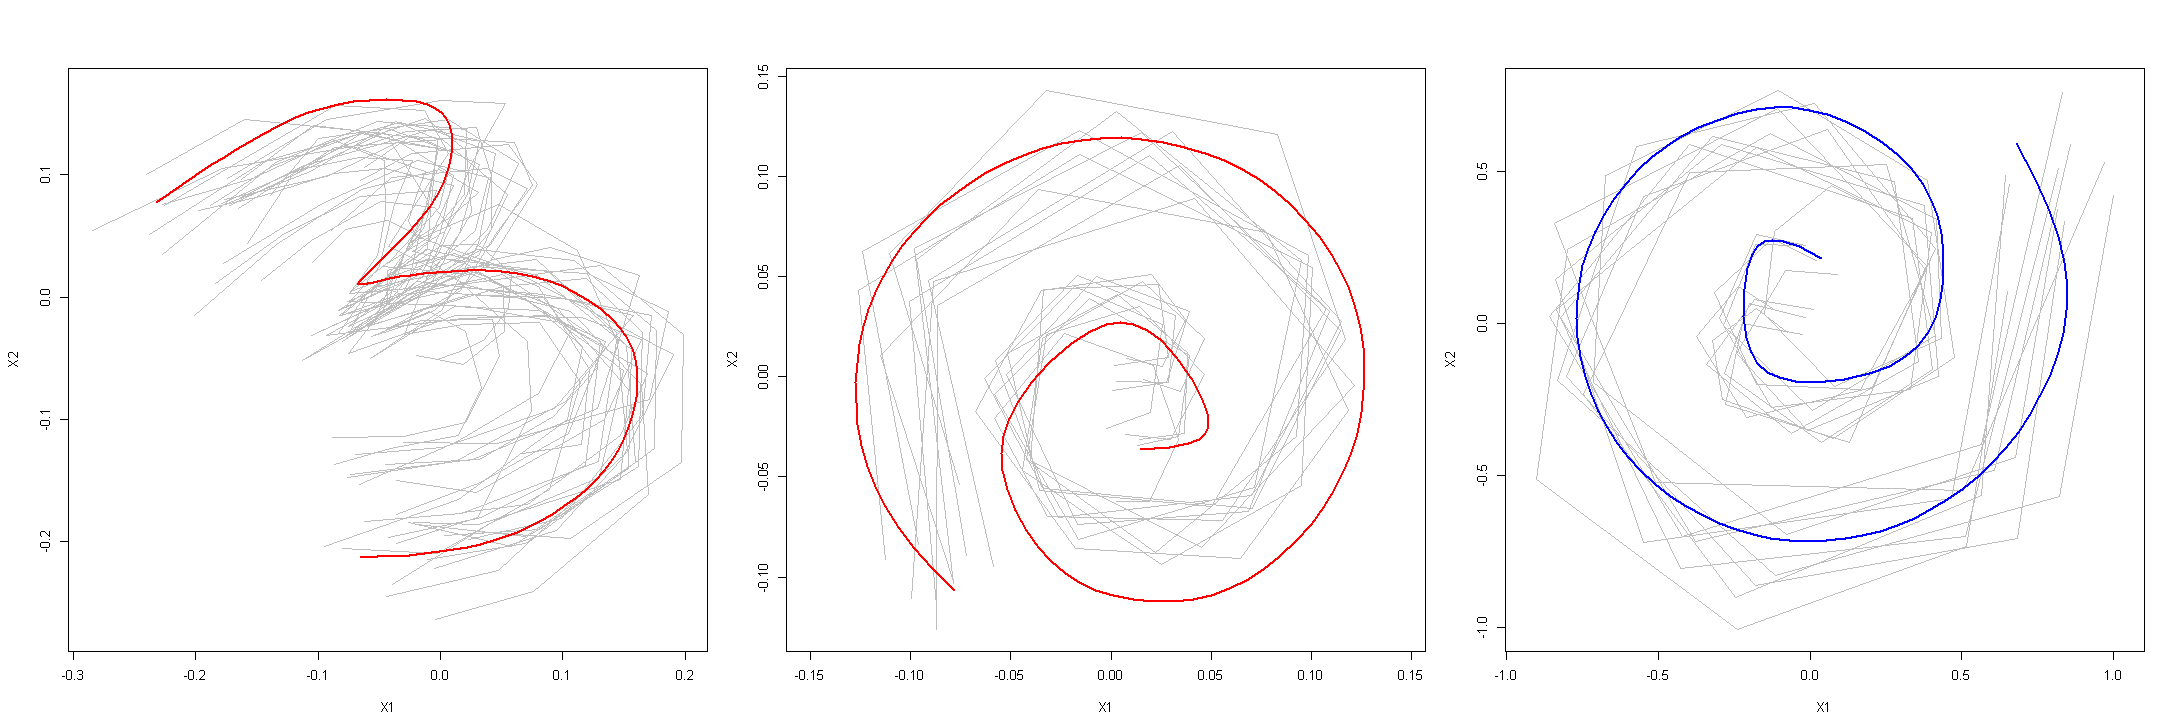

In [10]:
options(repr.plot.width=18, repr.plot.height=6)
par(mfrow=c(1,3), mar=c(4,4,4,1), oma=c(0.33,0.33,0.33,0))
plot(mean1)
plot(mean2)
plot(elastic_mean, col="blue")

## 2. Smooth Procrustes Fits

$\hat{p}(t) = b(t)^T \hat{\theta}$ estimated Procrustes mean function, $q$ piecewise constant SRV transform with $q|_{[t_j, t_{j+1}]} = q_j \in \mathbb{C}$.

For estimation of the Procrustes fits we need to estimate two scalar products:

$$ \hat{q}_{p} = \frac{\langle q,\hat{p} \rangle}{\langle q, q \rangle} q $$

### 2.1 Piecewise constant approximation
So far I treat $q$ as piecewise constant (as in Lisa's paper):

$$ \langle q, \hat{p} \rangle = \int_0^1 \langle q(t), \hat{p}(t) \rangle \, dt \approx \sum_{j=0}^{m-1} \int_{t_j}^{t_{j+1}} \langle q_j, \hat{p}(t) \rangle \, dt $$

$$ \langle q, q \rangle = \int_0^1 \langle q(t), q(t) \rangle \, dt \approx \sum_{j=0}^{m-1} (t_{j+1} - t_j) \, \langle q_j, q_j \rangle $$

### 2.2 Smooth approximation
Idea: Smooth $q$ in mean basis $b(t)$, so that $\hat{q}(t) = b(t)^T \hat{\theta}_q$. Then the scalar products simplify to 
$$ \langle q, \hat{p} \rangle \approx \hat{\theta}_q^H G \hat{\theta} $$ 
$$ \langle q, q \rangle \approx \hat{\theta}_q^H G \hat{\theta}_q $$

As $q$ can be sparse, we may want to use the estimated covariance matrix $\hat{\Xi}$ when estimating $\theta_q$ in the form of a Normal prior $\theta_q \sim \mathcal{N}_{\mathbb{C}^k}(0, \hat\Xi)$ leading to

$$ \hat\theta_q = (B^T B + \Xi^{-1})^{-1} B^T q $$

or equivalently using eigendecompositon $\Xi = V \Lambda V^{-1}$ with $V^H V = \mathcal{I}$ and $\Lambda = diag(\lambda_1, \dots, \lambda_k)$

$$ \hat\theta_q = V ( V^H B^T B V + \Lambda^{-1})^{-1} V^H B^T q$$

In general how well this works tends to depend on how close the curve is to the estimated mean.

Maybe using a penalty parameter - controling the strength of the regularization - is also thinkable? Something like this:

$$ \hat\theta_q(\lambda) = V ( V^H B^T B V + \lambda \cdot \Lambda^{-1})^{-1} V^H B^T q$$

**Thought**: A normal prior is probably not appropriate, because while its true that $\mathbb{E}[\theta] = 0$ (due to rotational symmetry) I would think that in general $\mathbb{E}[\lVert\theta\rVert] \neq 0$. A distribution more like a Normal distribution lying on a ring around 0 with radius $r = \lVert\theta\rVert$ is probably better? Then estimates wouldn't be pressed to zero so strongly, and instead would be pressed to curve of size equal to the mean.
#### Example with ```penalty = 2``` :

In [11]:
mean3 <- compute_elastic_proc2d_mean(data_curves1, knots = knots1, type = "smooth", penalty = 2, pfit_method = "smooth")
mean4 <- compute_elastic_proc2d_mean(data_curves2, knots = knots2, type = "smooth", penalty = 2, pfit_method = "smooth")

Warning message in smooth.construct.ps.smooth.spec(eval(as.call(list(as.symbol("s"), :
"there is *no* information about some basis coefficients"
Warning message in smooth.construct.ps.smooth.spec(eval(as.call(list(as.symbol("s"), :
"there is *no* information about some basis coefficients"
Warning message in smooth.construct.ps.smooth.spec(eval(as.call(list(as.symbol("s"), :
"there is *no* information about some basis coefficients"
Warning message in smooth.construct.ps.smooth.spec(eval(as.call(list(as.symbol("s"), :
"there is *no* information about some basis coefficients"
Warning message in smooth.construct.ps.smooth.spec(eval(as.call(list(as.symbol("s"), :
"there is *no* information about some basis coefficients"
Warning message in smooth.construct.ps.smooth.spec(eval(as.call(list(as.symbol("s"), :
"there is *no* information about some basis coefficients"
Warning message in smooth.construct.ps.smooth.spec(eval(as.call(list(as.symbol("s"), :
"there is *no* information about some basis

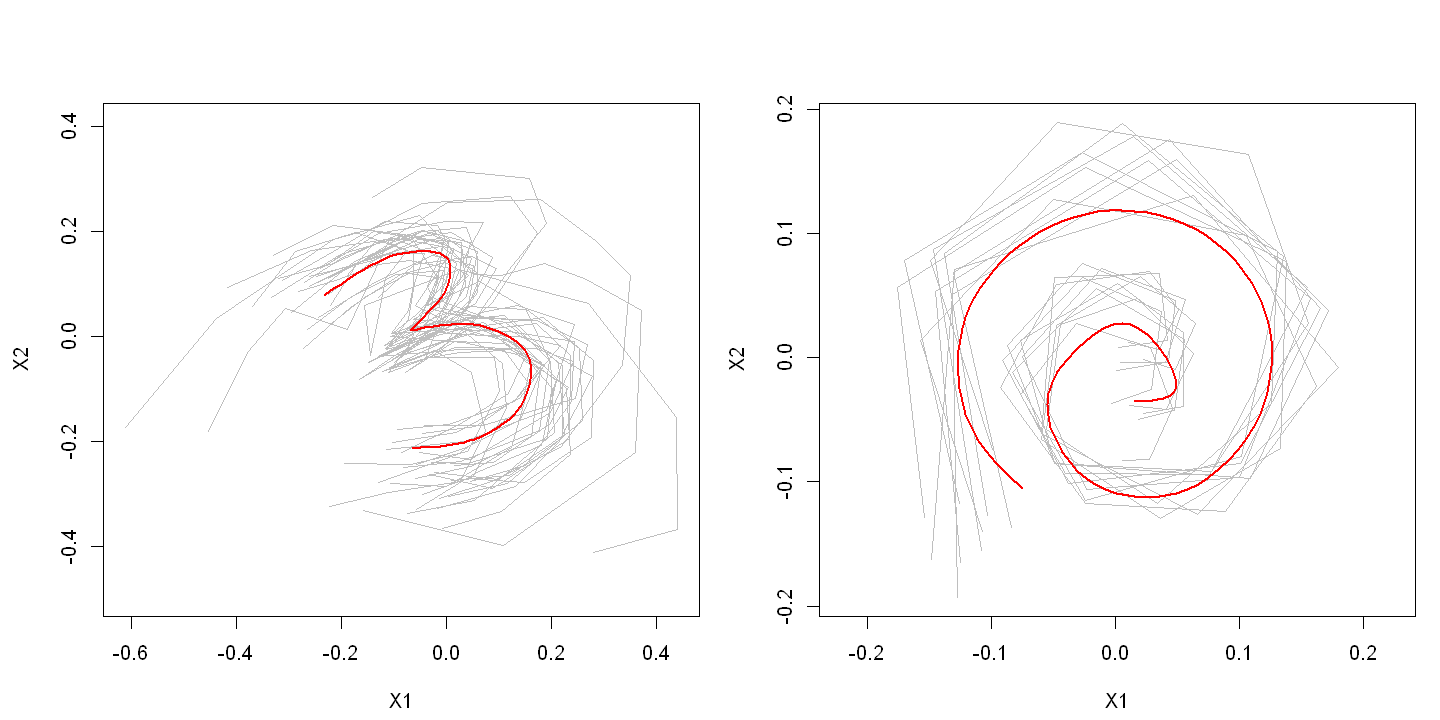

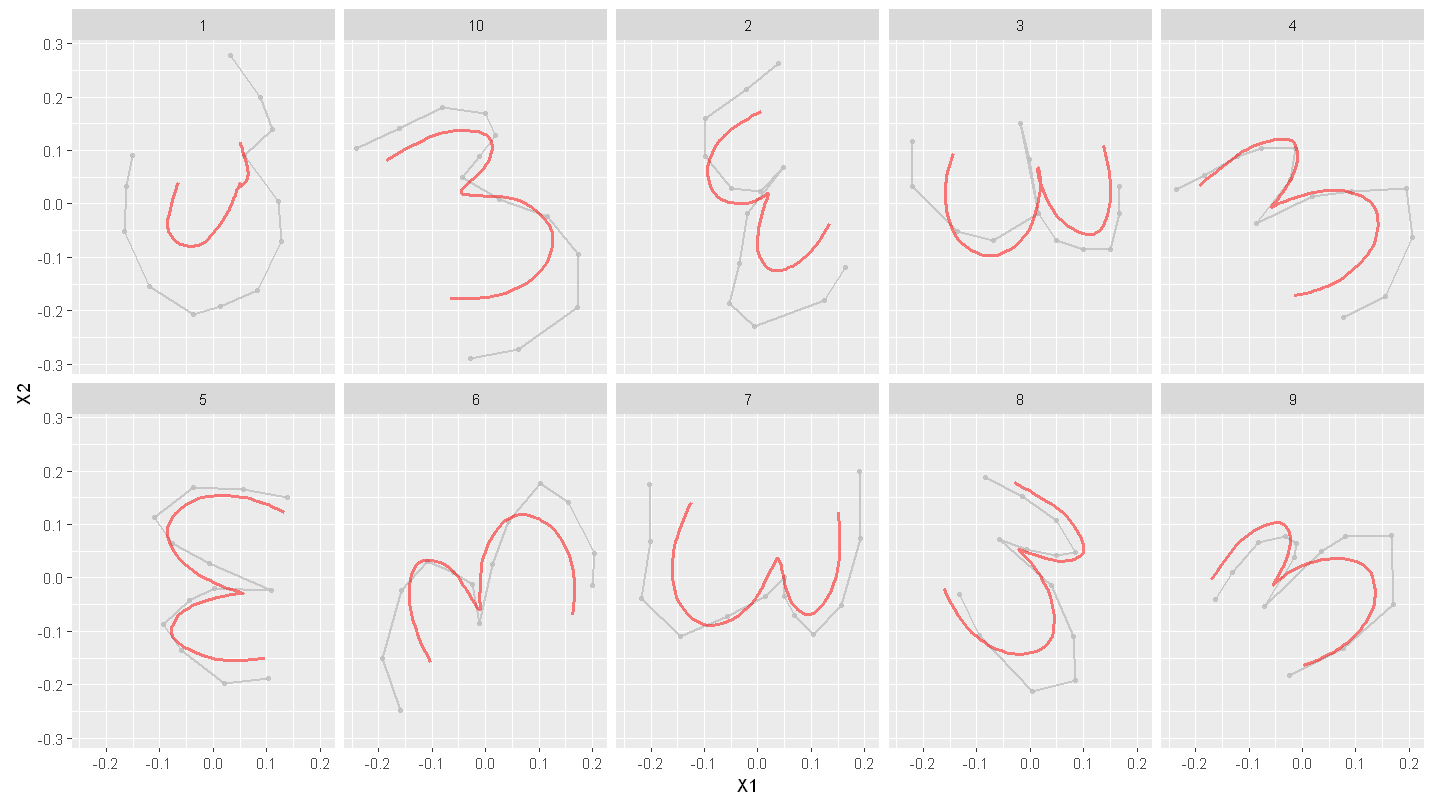

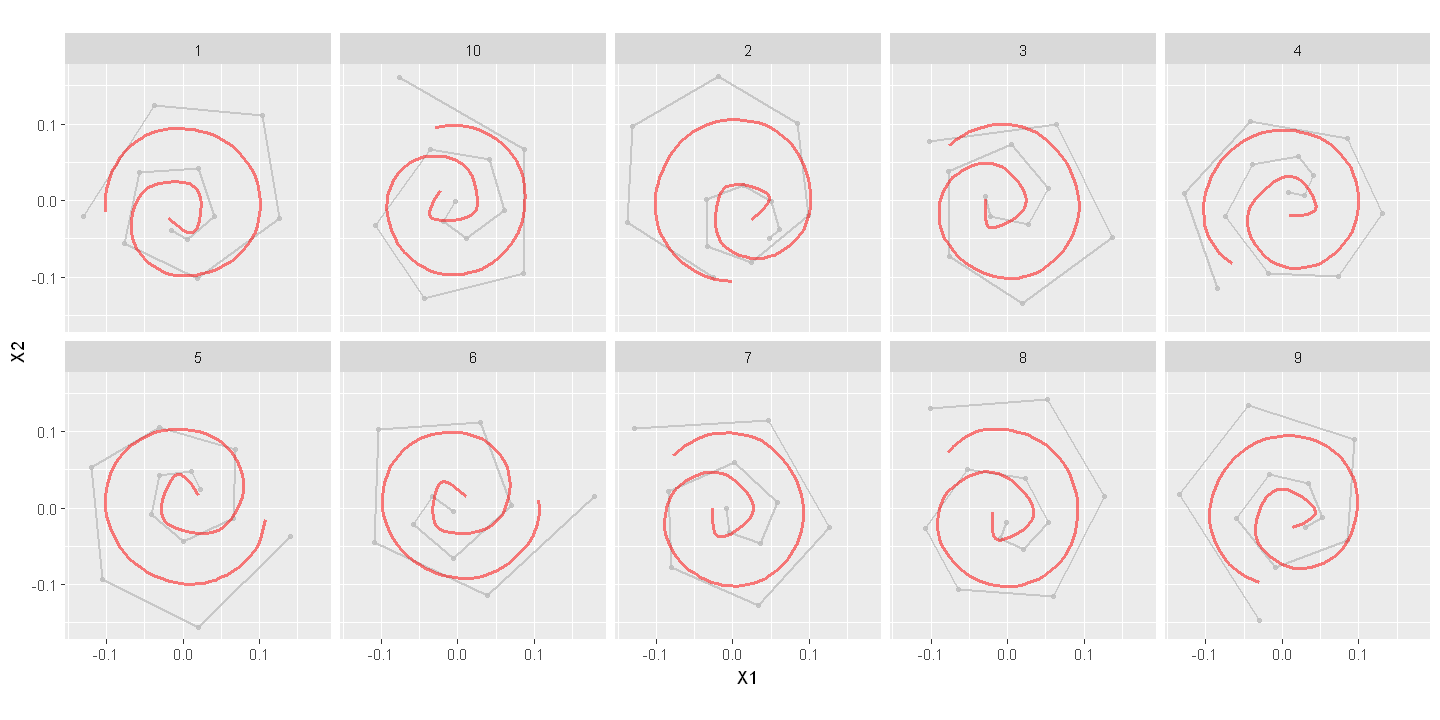

In [12]:
options(repr.plot.width=12, repr.plot.height=6)
par(mfrow=c(1,2), mar=c(4,4,4,1), oma=c(0.33,0.33,0.33,0))
plot(mean3)
plot(mean4)

pfits.smooth <- lapply(seq_along(mean3$data_curves), function(j){
  knots <- mean3$knots
  type <- mean3$type
  t <- seq(0, 1, by=0.01)
  srv.compl <- elasticproc2d:::make_design(t, knots, type) %*% mean3$fit$pfit_coefs[[j]]
  srv <- data.frame("t" = t, "X1" = Re(srv.compl), "X2" = Im(srv.compl))
  curve <- elasdics::get_points_from_srv(srv)
  center_curve(curve)
})[seq(1,10)]

pfits <- lapply(seq_along(mean3$data_curves), function(j){
    center_curve(mean3$data_curves[[j]])/elasticproc2d:::get_polygon_length(data_curves1[[j]])
})[seq(1,10)]


pfits.smooth2 <- lapply(seq_along(mean4$data_curves), function(j){
  knots <- mean4$knots
  type <- mean4$type
  t <- seq(0, 1, by=0.01)
  srv.compl <- elasticproc2d:::make_design(t, knots, type) %*% mean4$fit$pfit_coefs[[j]]
  srv <- data.frame("t" = t, "X1" = Re(srv.compl), "X2" = Im(srv.compl))
  curve <- elasdics::get_points_from_srv(srv)
  center_curve(curve)
})

pfits2 <- lapply(seq_along(mean4$data_curves), function(j){
    center_curve(mean4$data_curves[[j]])/elasticproc2d:::get_polygon_length(data_curves2[[j]])
})

options(repr.plot.width=12, repr.plot.height=6.7)
ggplot(bind_rows(pfits.smooth, .id="id"), aes(x=X1, y=X2)) + 
    geom_path(data=bind_rows(pfits, .id="id"), aes(x=X1, y=X2, group=id), size = 0.8, color="grey", alpha=0.8) +
    geom_point(data=bind_rows(pfits, .id="id"), aes(x=X1, y=X2, group=id), color="grey", size=1, alpha=0.8) +
    geom_path(aes(group=id), size = 1, color="red", alpha=0.5) +
    coord_fixed() +
    facet_wrap(~id, ncol=5)

options(repr.plot.width=12, repr.plot.height=6)
ggplot(bind_rows(pfits.smooth2, .id="id"), aes(x=X1, y=X2)) + 
    geom_path(data=bind_rows(pfits2, .id="id"), aes(x=X1, y=X2, group=id), size = 0.8, color="grey", alpha=0.8) +
    geom_point(data=bind_rows(pfits2, .id="id"), aes(x=X1, y=X2, group=id), color="grey", size=1, alpha=0.8) +
    geom_path(aes(group=id), size = 1, color="red", alpha=0.5) +
    coord_fixed() +
    facet_wrap(~id, ncol=5)

#### Example with ```penalty = 0``` :
How well the smoothing works depends on how well the covariance surface is estimated. I.e. for the spirals it fails for zero order penalty, because the estimation at the ends of the spirals is bad.

In [13]:
mean5 <- compute_elastic_proc2d_mean(data_curves1, knots = knots1, type = "smooth", penalty = 0, pfit_method = "smooth")
mean6 <- compute_elastic_proc2d_mean(data_curves2, knots = knots2, type = "smooth", penalty = 0, pfit_method = "smooth")

Warning message in smooth.construct.ps.smooth.spec(eval(as.call(list(as.symbol("s"), :
"there is *no* information about some basis coefficients"
Warning message in smooth.construct.ps.smooth.spec(eval(as.call(list(as.symbol("s"), :
"there is *no* information about some basis coefficients"
Warning message in smooth.construct.ps.smooth.spec(eval(as.call(list(as.symbol("s"), :
"there is *no* information about some basis coefficients"
Warning message in smooth.construct.ps.smooth.spec(eval(as.call(list(as.symbol("s"), :
"there is *no* information about some basis coefficients"
Warning message in smooth.construct.ps.smooth.spec(eval(as.call(list(as.symbol("s"), :
"there is *no* information about some basis coefficients"
Warning message in smooth.construct.ps.smooth.spec(eval(as.call(list(as.symbol("s"), :
"there is *no* information about some basis coefficients"
Warning message in smooth.construct.ps.smooth.spec(eval(as.call(list(as.symbol("s"), :
"there is *no* information about some basis

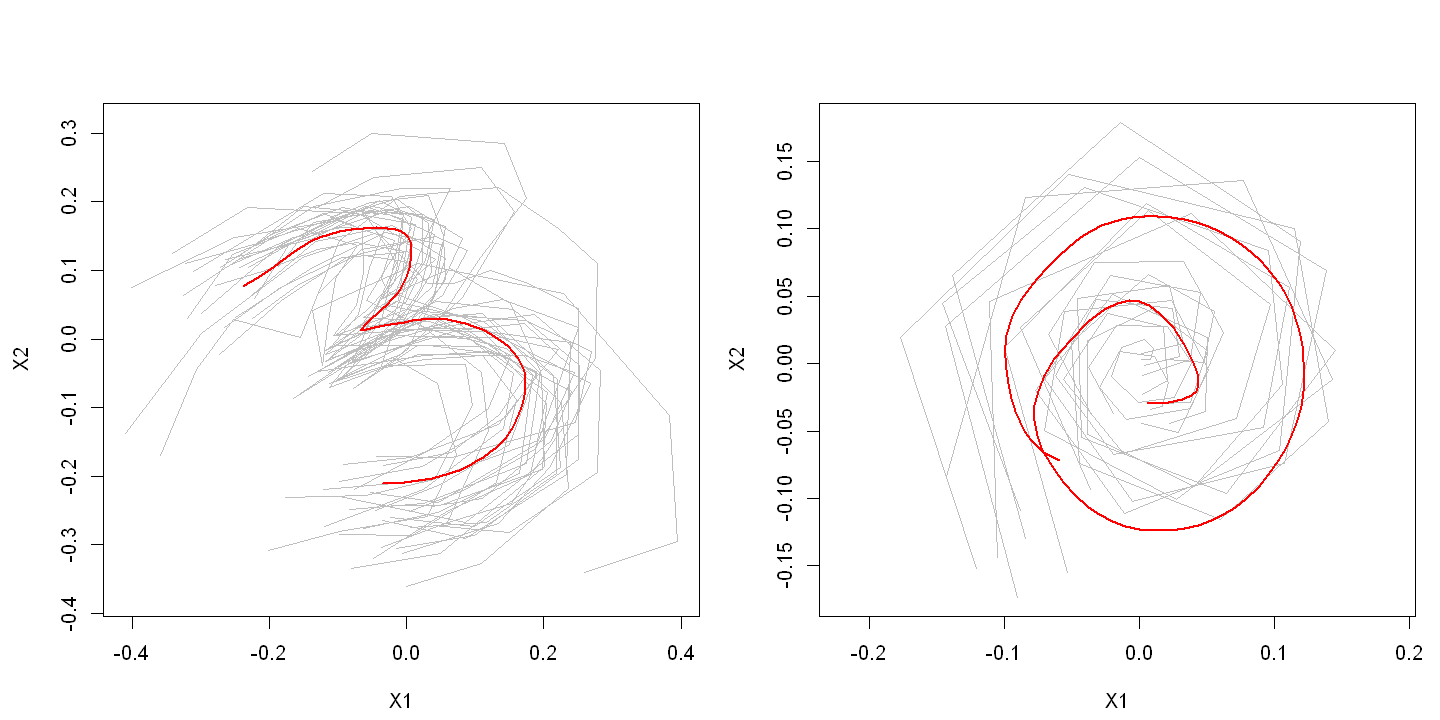

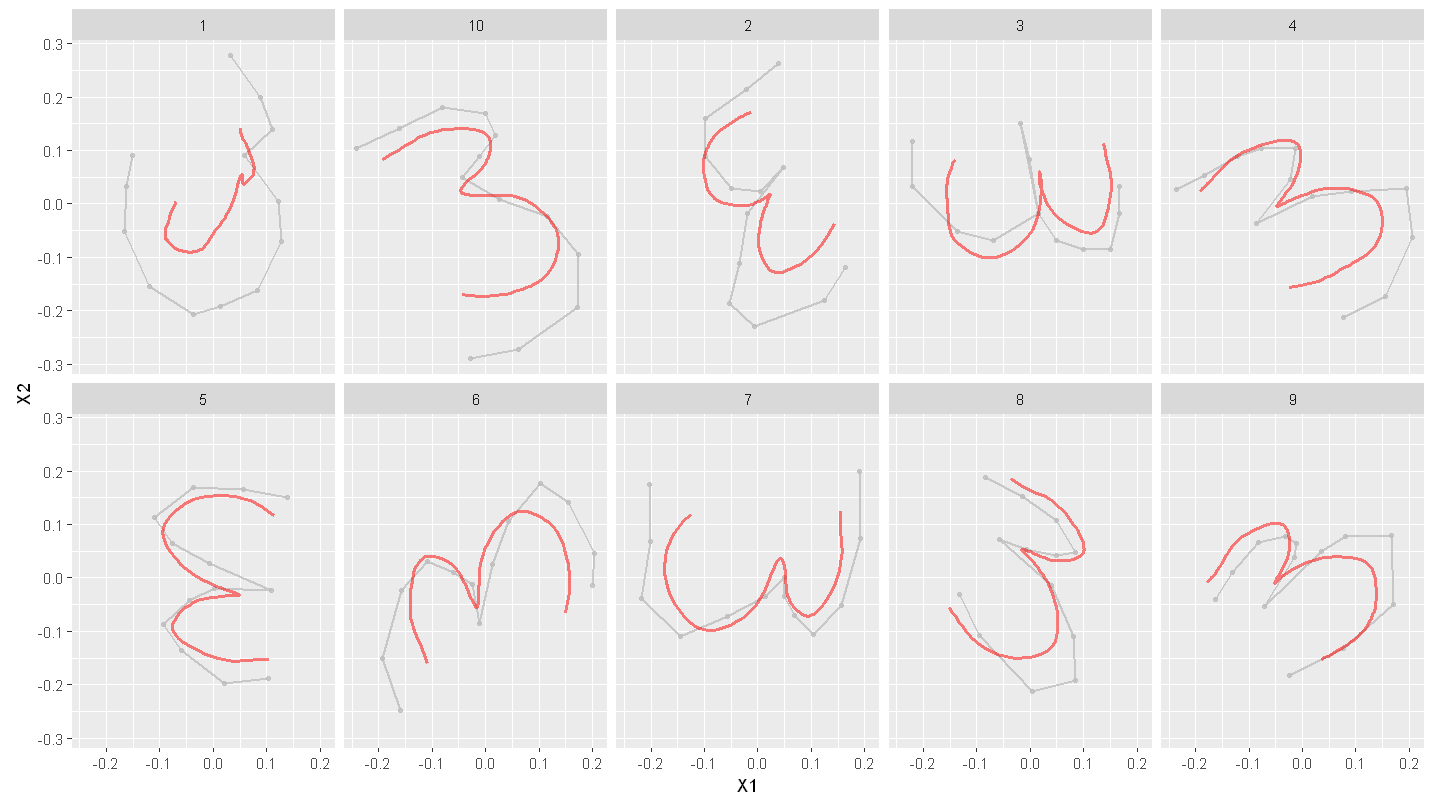

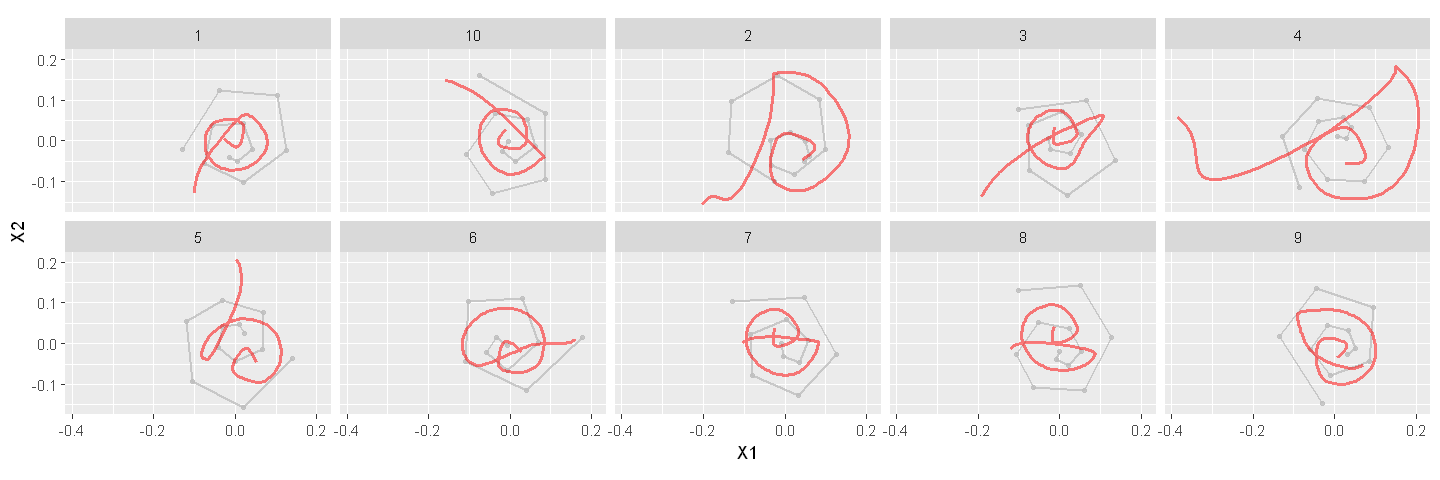

In [14]:
options(repr.plot.width=12, repr.plot.height=6)
par(mfrow=c(1,2), mar=c(4,4,4,1), oma=c(0.33,0.33,0.33,0))
plot(mean5)
plot(mean6)

pfits.smooth <- lapply(seq_along(mean6$data_curves), function(j){
  knots <- mean6$knots
  type <- mean6$type
  t <- seq(0, 1, by=0.01)
  srv.compl <- elasticproc2d:::make_design(t, knots, type) %*% mean6$fit$pfit_coefs[[j]]
  srv <- data.frame("t" = t, "X1" = Re(srv.compl), "X2" = Im(srv.compl))
  curve <- elasdics::get_points_from_srv(srv)
  center_curve(curve)
})

pfits <- lapply(seq_along(mean6$data_curves), function(j){
    center_curve(mean6$data_curves[[j]])/elasticproc2d:::get_polygon_length(data_curves2[[j]])
})


pfits.smooth2 <- lapply(seq_along(mean5$data_curves), function(j){
  knots <- mean5$knots
  type <- mean5$type
  t <- seq(0, 1, by=0.01)
  srv.compl <- elasticproc2d:::make_design(t, knots, type) %*% mean5$fit$pfit_coefs[[j]]
  srv <- data.frame("t" = t, "X1" = Re(srv.compl), "X2" = Im(srv.compl))
  curve <- elasdics::get_points_from_srv(srv)
  center_curve(curve)
})[seq(1,10)]

pfits2 <- lapply(seq_along(mean5$data_curves), function(j){
    center_curve(mean5$data_curves[[j]])/elasticproc2d:::get_polygon_length(data_curves1[[j]])
})[seq(1,10)]

options(repr.plot.width=12, repr.plot.height=6.7)
ggplot(bind_rows(pfits.smooth2, .id="id"), aes(x=X1, y=X2)) + 
    geom_path(data=bind_rows(pfits2, .id="id"), aes(x=X1, y=X2, group=id), size = 0.8, color="grey", alpha=0.8) +
    geom_point(data=bind_rows(pfits2, .id="id"), aes(x=X1, y=X2, group=id), color="grey", size=1, alpha=0.8) +
    geom_path(aes(group=id), size = 1, color="red", alpha=0.5) +
    coord_fixed() +
    facet_wrap(~id, ncol=5)

options(repr.plot.width=12, repr.plot.height=4)
ggplot(bind_rows(pfits.smooth, .id="id"), aes(x=X1, y=X2)) + 
    geom_path(data=bind_rows(pfits, .id="id"), aes(x=X1, y=X2, group=id), size = 0.8, color="grey", alpha=0.8) +
    geom_point(data=bind_rows(pfits, .id="id"), aes(x=X1, y=X2, group=id), color="grey", size=1, alpha=0.8) +
    geom_path(aes(group=id), size = 1, color="red", alpha=0.5) +
    coord_fixed() +
    facet_wrap(~id, ncol=5)

#### With $\lambda = 0.4$ and ```penalty = 2``` :

In [15]:
mean7 <- compute_elastic_proc2d_mean(data_curves1, knots = knots1, type = "smooth", penalty = 2, pfit_method = "smooth", pfit_pen_factor = 0.4)
mean8 <- compute_elastic_proc2d_mean(data_curves2, knots = knots2, type = "smooth", penalty = 2, pfit_method = "smooth", pfit_pen_factor = 0.4)

Warning message in smooth.construct.ps.smooth.spec(eval(as.call(list(as.symbol("s"), :
"there is *no* information about some basis coefficients"
Warning message in smooth.construct.ps.smooth.spec(eval(as.call(list(as.symbol("s"), :
"there is *no* information about some basis coefficients"
Warning message in smooth.construct.ps.smooth.spec(eval(as.call(list(as.symbol("s"), :
"there is *no* information about some basis coefficients"
Warning message in smooth.construct.ps.smooth.spec(eval(as.call(list(as.symbol("s"), :
"there is *no* information about some basis coefficients"
Warning message in smooth.construct.ps.smooth.spec(eval(as.call(list(as.symbol("s"), :
"there is *no* information about some basis coefficients"
Warning message in smooth.construct.ps.smooth.spec(eval(as.call(list(as.symbol("s"), :
"there is *no* information about some basis coefficients"
Warning message in smooth.construct.ps.smooth.spec(eval(as.call(list(as.symbol("s"), :
"there is *no* information about some basis

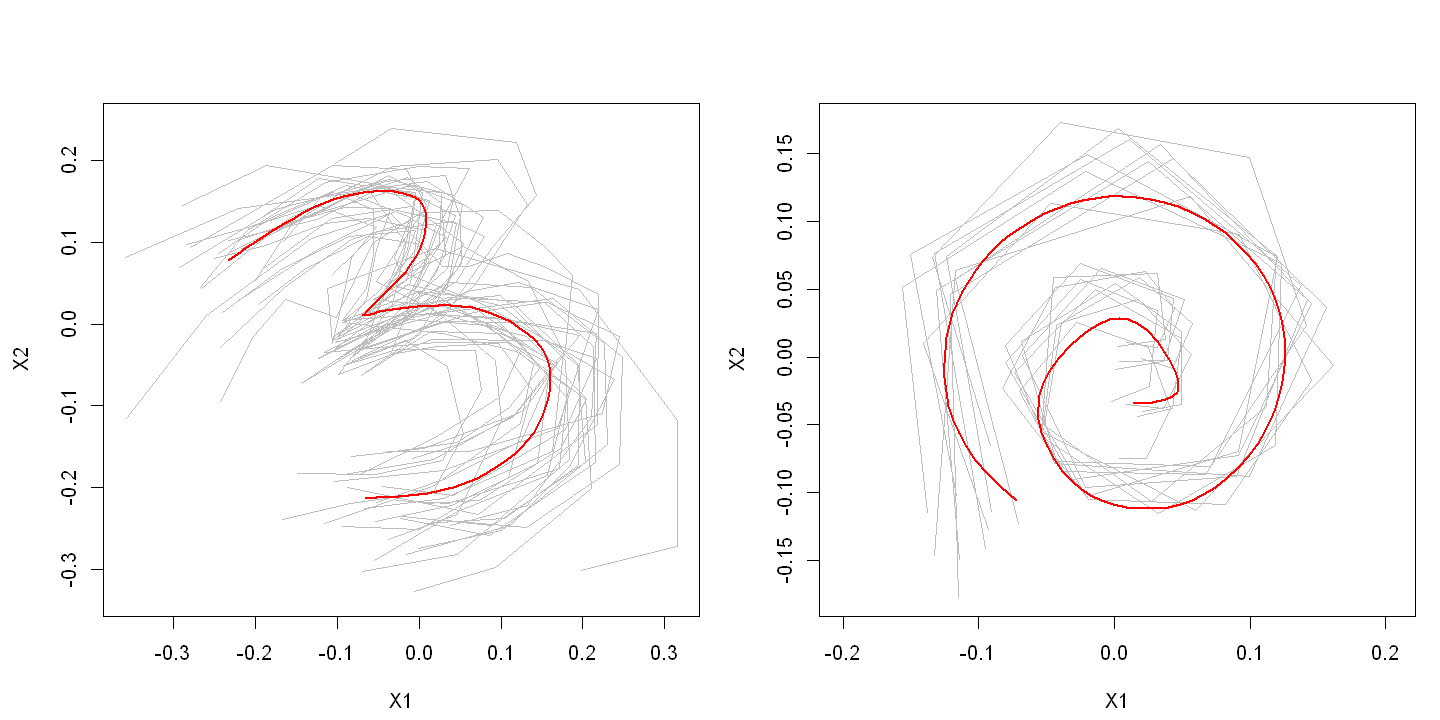

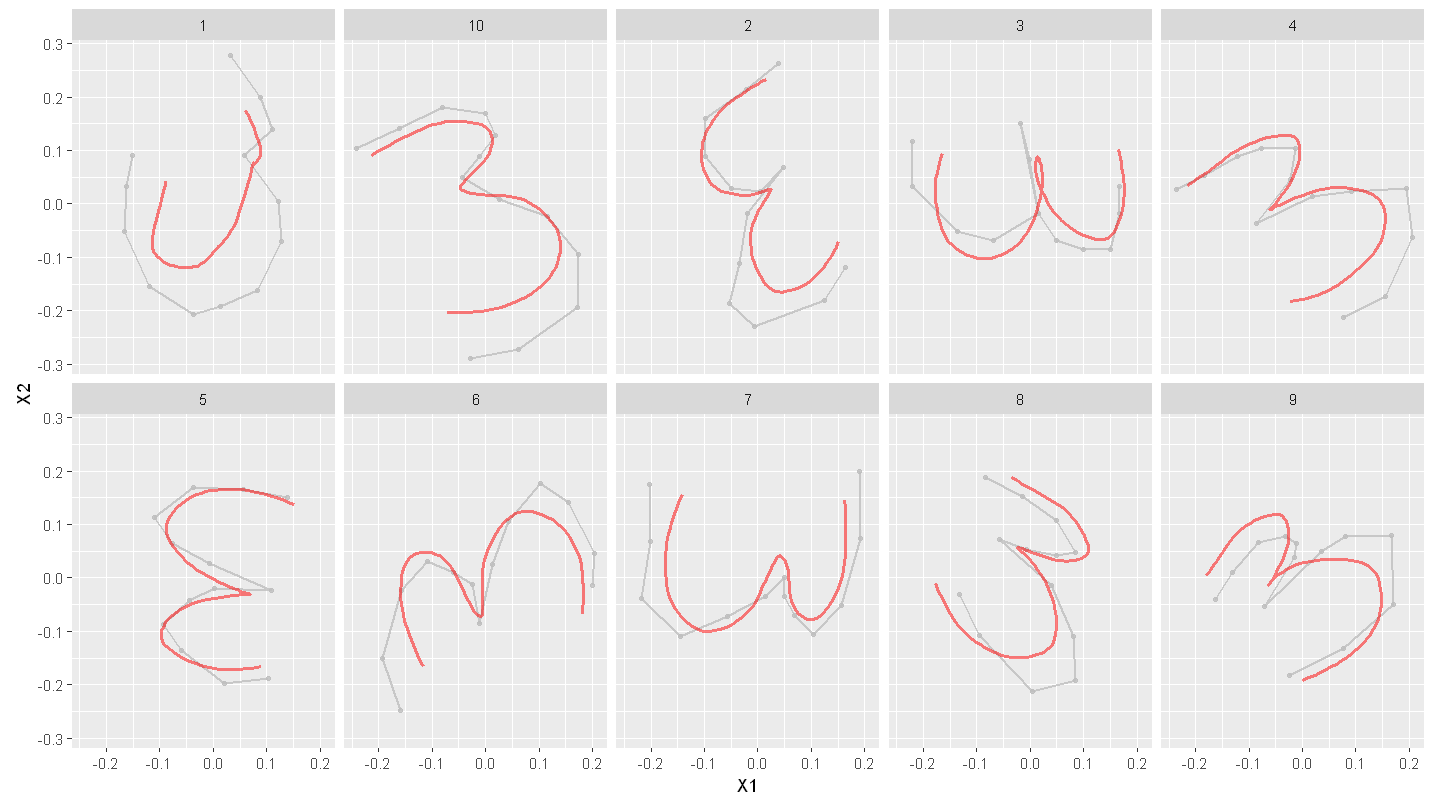

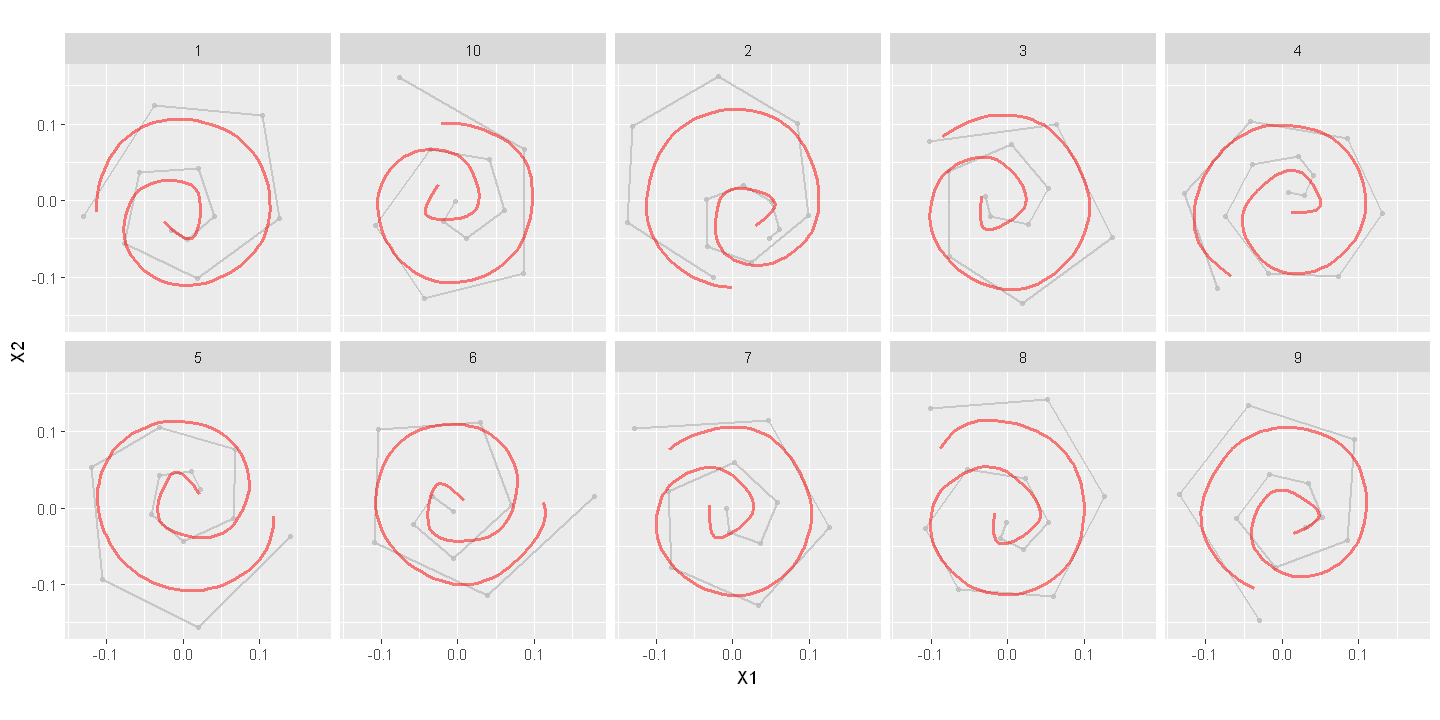

In [16]:
options(repr.plot.width=12, repr.plot.height=6)
par(mfrow=c(1,2), mar=c(4,4,4,1), oma=c(0.33,0.33,0.33,0))
plot(mean7)
plot(mean8)

pfits.smooth <- lapply(seq_along(mean8$data_curves), function(j){
  knots <- mean8$knots
  type <- mean8$type
  t <- seq(0, 1, by=0.01)
  srv.compl <- elasticproc2d:::make_design(t, knots, type) %*% mean8$fit$pfit_coefs[[j]]
  srv <- data.frame("t" = t, "X1" = Re(srv.compl), "X2" = Im(srv.compl))
  curve <- elasdics::get_points_from_srv(srv)
  center_curve(curve)
})

pfits <- lapply(seq_along(mean8$data_curves), function(j){
    center_curve(mean8$data_curves[[j]])/elasticproc2d:::get_polygon_length(data_curves2[[j]])
})


pfits.smooth2 <- lapply(seq_along(mean7$data_curves), function(j){
  knots <- mean7$knots
  type <- mean7$type
  t <- seq(0, 1, by=0.01)
  srv.compl <- elasticproc2d:::make_design(t, knots, type) %*% mean7$fit$pfit_coefs[[j]]
  srv <- data.frame("t" = t, "X1" = Re(srv.compl), "X2" = Im(srv.compl))
  curve <- elasdics::get_points_from_srv(srv)
  center_curve(curve)
})[seq(1,10)]

pfits2 <- lapply(seq_along(mean7$data_curves), function(j){
    center_curve(mean7$data_curves[[j]])/elasticproc2d:::get_polygon_length(data_curves1[[j]])
})[seq(1,10)]

options(repr.plot.width=12, repr.plot.height=6.7)
ggplot(bind_rows(pfits.smooth2, .id="id"), aes(x=X1, y=X2)) + 
    geom_path(data=bind_rows(pfits2, .id="id"), aes(x=X1, y=X2, group=id), size = 0.8, color="grey", alpha=0.8) +
    geom_point(data=bind_rows(pfits2, .id="id"), aes(x=X1, y=X2, group=id), color="grey", size=1, alpha=0.8) +
    geom_path(aes(group=id), size = 1, color="red", alpha=0.5) +
    coord_fixed() +
    facet_wrap(~id, ncol=5)

options(repr.plot.width=12, repr.plot.height=6)
ggplot(bind_rows(pfits.smooth, .id="id"), aes(x=X1, y=X2)) + 
    geom_path(data=bind_rows(pfits, .id="id"), aes(x=X1, y=X2, group=id), size = 0.8, color="grey", alpha=0.8) +
    geom_point(data=bind_rows(pfits, .id="id"), aes(x=X1, y=X2, group=id), color="grey", size=1, alpha=0.8) +
    geom_path(aes(group=id), size = 1, color="red", alpha=0.5) +
    coord_fixed() +
    facet_wrap(~id, ncol=5)

## 3. Closed means

Mean $p(t) = b(t)^T\theta$  with $b(t)$ being B-spline basis functions with corresponding Gram matrix $G$. 

Then the procrustes mean in an fixed basis is given by the solution to following optimization problem on the coefficient vector:

$$ \hat{\theta} = \underset{\theta \in \mathbb{C}^k}{\arg\max} \,\,\, \theta^H G \hat\Xi G \theta \qquad \text{s.t.} \quad \theta^H G \theta = 1$$

For a closed mean, we additionally want that $||\hat\mu(1) - \hat\mu(0)||^2 = 0$. We can rewrite this on SRV level as 

$$ \lVert\hat\mu(1) - \hat\mu(0)\rVert^2 = \left\lVert\int_0^1 \hat p(t) \lVert \hat p(t) \rVert \, dt \right\rVert^2 $$

It would be nice to write this restriction as a restriction on $\theta$. Maybe like this?

$$ \left\lVert\int_0^1 b(t)^T \theta \lVert b(t)^T \theta \rVert dt \right\rVert^2
    \overset{?? \, DU, \, b(t)\geq 0}{\leq} \left\lVert \int_0^1 b(t)^T \theta \, b(t)^T \theta_{\lVert\cdot\rVert} dt \right\rVert^2 
    = \left\lVert \int_0^1 \theta^T b(t) \, b(t)^T \theta_{\lVert\cdot\rVert} dt \right\rVert^2
    = \left\lVert \theta^T \int_0^1 b(t) \, b(t)^T dt \, \theta_{\lVert\cdot\rVert} \right\rVert^2 $$
    
$$  = \left\lVert \theta^T G \theta_{\lVert\cdot\rVert} \right\rVert^2 
    = \left\lVert \theta_{\lVert\cdot\rVert}^T G \theta \right\rVert^2
    =\theta^H G \theta_{\lVert\cdot\rVert} \theta_{\lVert\cdot\rVert}^T G \theta $$

Where $\theta_{\lVert\cdot\rVert}$ denotes the element-wise norm $\left(\lVert\theta_i\rVert\right)_{i=1,\dots,k}$. Maybe the term $\theta_{\lVert\cdot\rVert} \theta_{\lVert\cdot\rVert}^T$ can be simplified or bound from above further?

With estimated coefficient matrix $\hat{\Xi}$, so that $\hat{C}(s,t) = b(s)^T\hat\Xi b(t)$ is closed, we end up with the optimization problem for the closed mean:

$$ \hat{\theta} = \underset{\theta \in \mathbb{C}^k}{\arg\max} \,\,\, \theta^H G \hat\Xi G \theta \qquad \text{s.t.} \quad \theta^H G \theta = 1 \,\,\,\,\text{and}\,\,\,\, \theta^H G \theta_{\lVert\cdot\rVert} \theta_{\lVert\cdot\rVert}^T G \theta = 0 $$


## 4. Phonetics data

In dem Consulting Projekt wurde der Einfluss der **"flankierenden Vokale des Konsonanten auf die Zungenkontur"** untersucht. Also z.B. wie sich die Zungenkontur "pada" vs. "pidi" unterscheidet. Dabei hat man in den Zungenkonturen drei Arten der Varibilität, einmal über die Vokalkontexte, einmal über die Versuchspersonen und einmal über die Wiederholungen pro Versuchsperson.

In [17]:
library(grid)
library(gridExtra)


Attaching package: 'gridExtra'


The following object is masked from 'package:dplyr':

    combine




In [18]:
# From '..phonetik/code/Rfiles/readdata.R'
pouplier <- read.csv(file = "../data/phonetik_consulting/Daten/UltrasoundData_Frame3_AllSpeakers.txt", sep = "\t", header = TRUE)
pouplier$COMPL <- pouplier$RHO * exp(1.i*pouplier$THETA)
pouplier$X1 <- Re(pouplier$COMPL)
pouplier$X2 <- Im(pouplier$COMPL)

In [19]:
head(pouplier)

,VPN,REP,FRAME,WORD,VCODE,CCODE,THETA,RHO,COMPL,X1,X2
,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<cpl>,<dbl>,<dbl>
1,D1,1,3,pada,aa,d,1.037,57.0108,29.00739+49.07955i,29.00739,49.07955
2,D1,1,3,pada,aa,d,1.088,56.9207,26.42587+50.41467i,26.42587,50.41467
3,D1,1,3,pada,aa,d,1.138,56.2112,23.57559+51.02833i,23.57559,51.02833
4,D1,1,3,pada,aa,d,1.189,54.8924,20.45225+50.93997i,20.45225,50.93997
5,D1,1,3,pada,aa,d,1.239,53.9110,17.56107+50.97063i,17.56107,50.97063
6,D1,1,3,pada,aa,d,1.290,53.1188,14.72033+51.03841i,14.72033,51.03841


An sich würde ich einfach vorschlagen genau die Varibilität entlang der Zunge zwischen den Vokalkontexten zu untersuchen und dabei für die Versuchspersonen zu kontrollieren. Die Unterschiede über die Wiederholungen sollten ja eher random noise sein. 

#### 4.1 Estimation via Regression

Also man hat dann sowas wie:

$$ y_i(t) = \beta_0(t) + D_{Vokal,i} * \beta_{Vokal}(t) + D_{Pers, i} * \beta_{Pers}(t) + \epsilon_i(t) $$

Und was einen dann interessiert ist sowas wie:

$$ \mathbb{E}\left[ (y_i | D_{Vokal, i} = \text{"a"})  - (y_i | D_{Vokal, i} = \text{"i"}) \right](t) = \beta_{\text{Vokal "a"}}(t) - \beta_{\text{Vokal "i"}}(t) $$

#### 4.2 Estimation via step-wise Means

Da uns nur Mean-Berechnung zur Verfügung steht, können wir obiges Modell nicht einfach schätze. Am einfachsten wäre es daher für jede Beobachtung 

$$ d_i(t) = (y_i(t) | D_{Vokal, i} = \text{"a"})  - (y_i(t) | D_{Vokal, i} = \text{"i"}) $$

direkt auszurechnen und dann einfach den Mean über $d_i$ zu bilden. Allerdings haben wir pro Beobachtung nur entweder $y_i | D_{Vokal, i} = \text{"a"}$ oder $y_i | D_{Vokal, i} = \text{"i"}$ beobachtet, aber nie beides.

Wir müssen $d_i(t)$ also irgendwie abschätzen. Der Erwartungswert von $d_i(t)$ ist gegeben als:

$$ \mathbb{E}\left[d_i\right](t) = \mathbb{E}\left[y_i | D_{Vokal, i} = \text{"a"}\right](t)  - \mathbb{E}\left[y_i | D_{Vokal, i} = \text{"i"}\right](t) $$

Was mir mit LIE umschreiben können als

$$ \mathbb{E}\left[d_i\right](t) = \mathbb{E}\left[ \mathbb{E}\left[d_i | D_{Pers} \right]\right](t) = \mathbb{E}\left[ \mathbb{E}\left[y_i | D_{Vokal, i} = \text{"a"}, D_{Pers, i} \right]  - \mathbb{E}\left[y_i | D_{Vokal, i} = \text{"i"}, D_{Pers, i}\right] \right](t) $$

Da uns pro Versuchsperson und pro Vokal mehrere Wiederholungen zur Verfügung stehen, können wir $\mathbb{E}\left[y_i | D_{Vokal, i}, D_{Pers, i} \right] $ über Mean-Berechnung schätzen und bekommen dadurch einen Schätzer für $\mathbb{E}\left[d_i | D_{Pers} \right]$:

$$ \hat{d}_{D_{Pers}} (t) = \bar{y}(t)|_{D_{Vokal} = \text{"a"}, D_{Pers}} - \bar{y}(t)|_{D_{Vokal} = \text{"i"}, D_{Pers}}$$

Schlussendlich bekommen wir einen Schätzer für $d(t)$ als Mean $\bar{d}(t)$ der $\hat{d}_{D_{Pers}}(t)$.

Am Ende interessiert uns dann vielleicht auch eher $\lVert d(t) \rVert$ (Größe der Differenz entlang $t$, also entlang der Zunge).

#### Zungendaten für "pada" and "pidi"

Erstmal ganz einfache total means für beide Vokalkontexte.

In [20]:
pada <- pouplier %>%
    filter(WORD == "pada") %>%
    select(VPN, REP, X1, X2) %>%
    group_by(VPN, REP) %>%
    group_split(.keep = FALSE)

pidi <- pouplier %>%
    filter(WORD == "pidi") %>%
    select(VPN, REP, X1, X2) %>%
    group_by(VPN, REP) %>%
    group_split(.keep = FALSE)

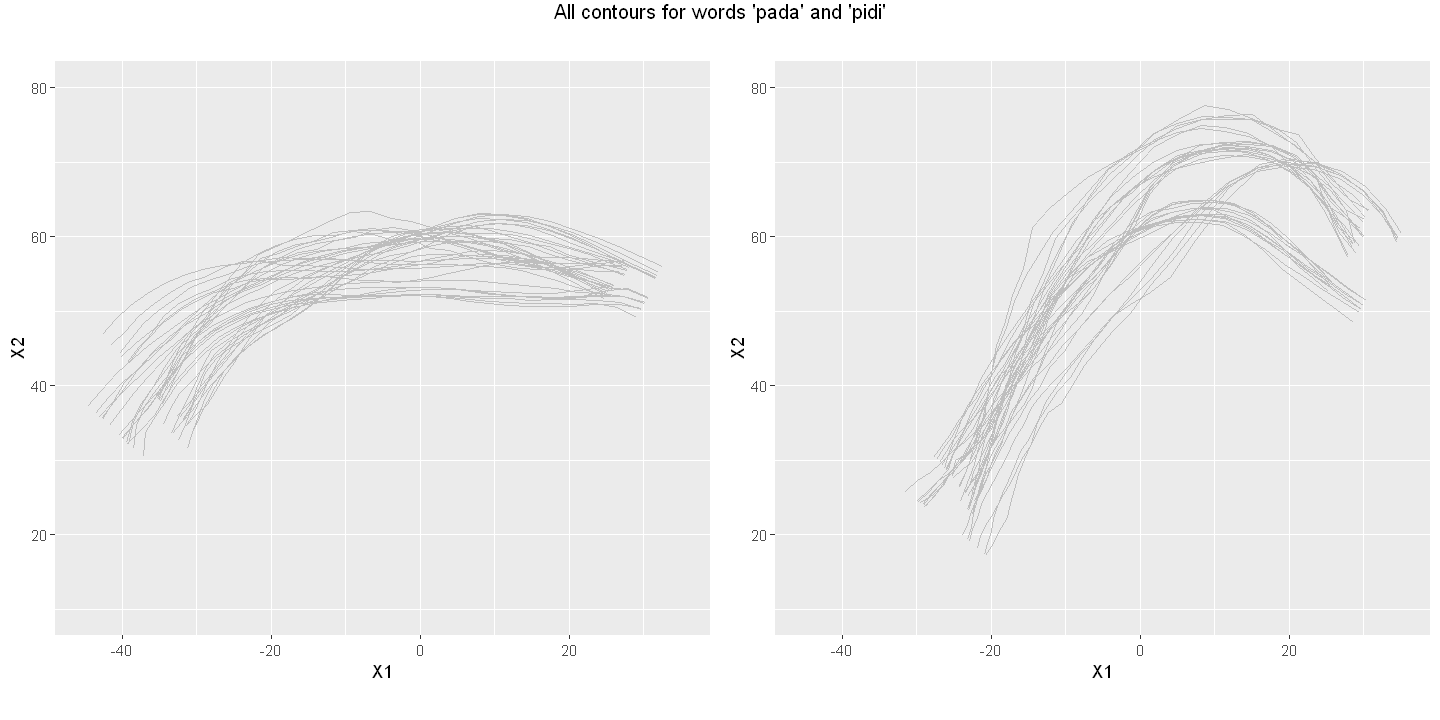

In [21]:
p1 <- ggplot(bind_rows(pada, .id="id"), aes(x=X1, y=X2)) + 
    geom_path(size=0.5, aes(group=id), color="grey") +
    coord_fixed(xlim=c(-45,35), ylim=c(10,80))

p2 <- ggplot(bind_rows(pidi, .id="id"), aes(x=X1, y=X2)) + 
    geom_path(size=0.5, aes(group=id), color="grey") +
    coord_fixed(xlim=c(-45,35), ylim=c(10,80))

options(repr.plot.width=12, repr.plot.height=6)
grid.arrange(p1, p2, nrow=1, top="All contours for words 'pada' and 'pidi'")

In [22]:
knots <- seq(0, 1, length = 30)
pada.mean <- compute_elastic_proc2d_mean(pada, knots = knots, type = "smooth", penalty = 2)
pidi.mean <- compute_elastic_proc2d_mean(pidi, knots = knots, type = "smooth", penalty = 2)

Warning message in smooth.construct.ps.smooth.spec(eval(as.call(list(as.symbol("s"), :
"there is *no* information about some basis coefficients"
Warning message in smooth.construct.ps.smooth.spec(eval(as.call(list(as.symbol("s"), :
"there is *no* information about some basis coefficients"
Warning message in smooth.construct.ps.smooth.spec(eval(as.call(list(as.symbol("s"), :
"there is *no* information about some basis coefficients"
Warning message in smooth.construct.ps.smooth.spec(eval(as.call(list(as.symbol("s"), :
"there is *no* information about some basis coefficients"
Warning message in smooth.construct.ps.smooth.spec(eval(as.call(list(as.symbol("s"), :
"there is *no* information about some basis coefficients"
Warning message in smooth.construct.ps.smooth.spec(eval(as.call(list(as.symbol("s"), :
"there is *no* information about some basis coefficients"
Warning message in smooth.construct.ps.smooth.spec(eval(as.call(list(as.symbol("s"), :
"there is *no* information about some basis

In [23]:
rot.pada <- mean(sapply(pada.mean$data_curves, function(curve){
    attr(curve, "rotation")
}))
rot.pidi <- mean(sapply(pidi.mean$data_curves, function(curve){
    attr(curve, "rotation")
}))

In [25]:
pfits.pada <- lapply(pada.mean$data_curves, function(curve){
    pfit <- get_procrustes_fit(curve)
    theta <- - rot.pada
    mat <- matrix(c(cos(theta), - sin(theta), sin(theta), cos(theta)), nrow = 2, ncol = 2)
    curve <- as.data.frame(as.matrix(pfit[,c(3,4)]) %*% mat)
    curve[,1] <- curve[,1] - curve[nrow(curve),1]
    curve[,2] <- curve[,2] - curve[nrow(curve),2]
    colnames(curve) <- c("X1", "X2")
    curve
})
theta <- - rot.pada
mat <- matrix(c(cos(theta), - sin(theta), sin(theta), cos(theta)), nrow = 2, ncol = 2)
mean.pada.rot <- as.data.frame(as.matrix(get_evals(pada.mean)) %*% mat)
mean.pada.rot[,1] <- mean.pada.rot[,1] - mean.pada.rot[nrow(mean.pada.rot),1]
mean.pada.rot[,2] <- mean.pada.rot[,2] - mean.pada.rot[nrow(mean.pada.rot),2]
colnames(mean.pada.rot) <- c("X1", "X2")

pfits.pidi <- lapply(pidi.mean$data_curves, function(curve){
    pfit <- get_procrustes_fit(curve)
    theta <- - rot.pidi
    mat <- matrix(c(cos(theta), - sin(theta), sin(theta), cos(theta)), nrow = 2, ncol = 2)
    curve <- as.data.frame(as.matrix(pfit[,c(3,4)]) %*% mat)
    curve[,1] <- curve[,1] - curve[nrow(curve),1]
    curve[,2] <- curve[,2] - curve[nrow(curve),2]
    colnames(curve) <- c("X1", "X2")
    curve
})
theta <- - rot.pidi
mat <- matrix(c(cos(theta), - sin(theta), sin(theta), cos(theta)), nrow = 2, ncol = 2)
mean.pidi.rot <- as.data.frame(as.matrix(get_evals(pidi.mean)) %*% mat)
mean.pidi.rot[,1] <- mean.pidi.rot[,1] - mean.pidi.rot[nrow(mean.pidi.rot),1]
mean.pidi.rot[,2] <- mean.pidi.rot[,2] - mean.pidi.rot[nrow(mean.pidi.rot),2]
colnames(mean.pidi.rot) <- c("X1", "X2")

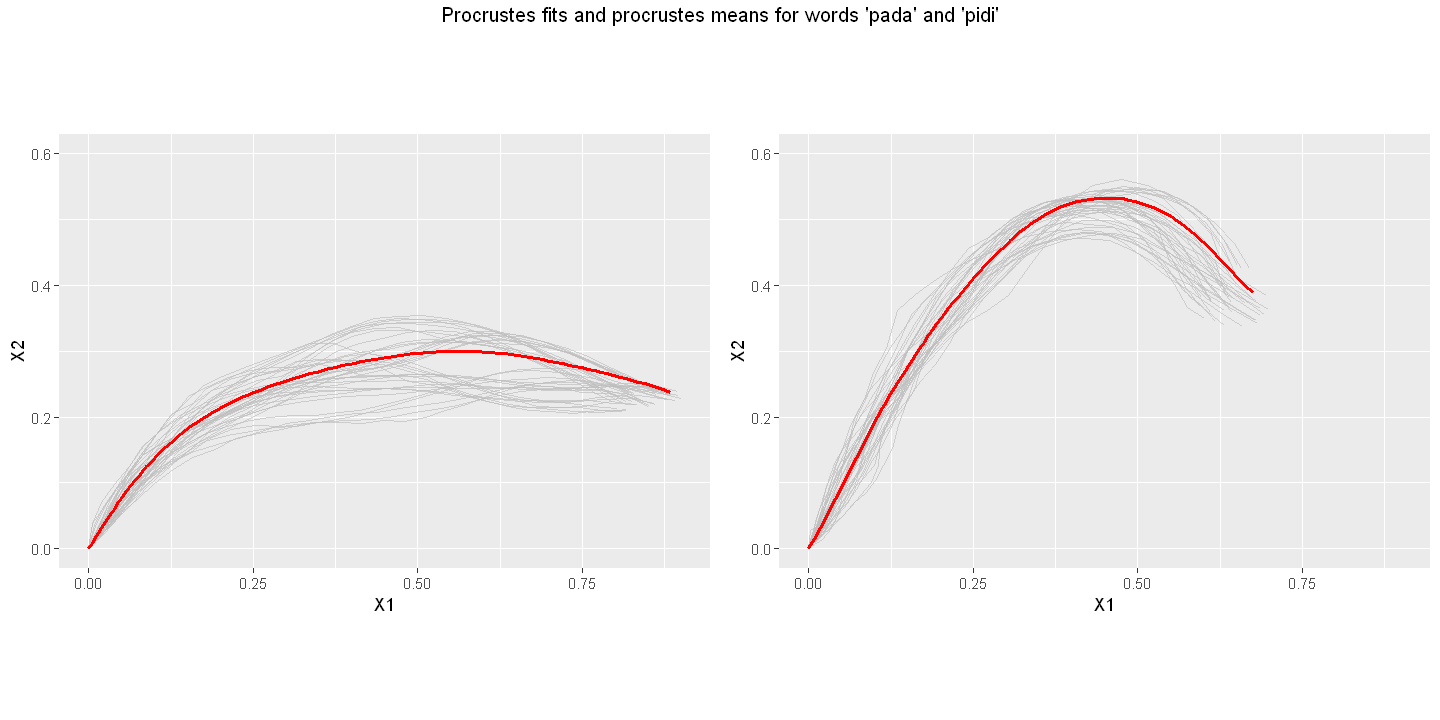

In [29]:
p1 <- ggplot(bind_rows(pfits.pada, .id="id"), aes(x=X1, y=X2)) + 
    geom_path(size=0.5, aes(group=id), color="grey", alpha=0.7) +
    geom_path(data=mean.pada.rot, aes(x=X1, y=X2), size=1, color="red") +
    coord_fixed(xlim=c(0,0.9),ylim=c(0,0.6))

p2 <- ggplot(bind_rows(pfits.pidi, .id="id"), aes(x=X1, y=X2)) + 
    geom_path(size=0.5, aes(group=id), color="grey", alpha=0.7) +
    geom_path(data=mean.pidi.rot, aes(x=X1, y=X2), size=1, color="red") +
    coord_fixed(xlim=c(0,0.9),ylim=c(0,0.6))

options(repr.plot.width=12, repr.plot.height=6)
grid.arrange(p1, p2, nrow=1, top="Procrustes fits and procrustes means for words 'pada' and 'pidi'")